In [75]:
#! pip -q install pandas matplotlib
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [77]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [78]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'school_holidays', 'shops_closed', 'frankfurt_shutdown', 'warehouse', 'precipitation', 'shutdown', 'winter_school_holidays', 'snow', 'mini_shutdown', 'holiday', 'holiday_name', 'mov_change', 'date', 'blackout'}
No differences found in column: school_holidays
No differences found in column: shops_closed
No differences found in column: frankfurt_shutdown
No differences found in column: precipitation
No differences found in column: shutdown
No differences found in column: winter_school_holidays
No differences found in column: snow
No differences found in column: mini_shutdown
No differences found in column: holiday
No differences found in column: holiday_name
No differences found in column: mov_change
No differences found in column: blackout

Success. All values match across the datasets, datasets merged.
{'school_holidays', 'shops_closed', 'warehouse', 'winter_school_holidays', 'holiday', 'holiday_name', 'date'}
No differences found in column: school_holidays
No differences found in col

In [79]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [80]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['frankfurt_shutdown', 'precipitation', 'shutdown', 'user_activity_1', 'snow', 'mini_shutdown', 'user_activity_2', 'warehouse_limited', 'mov_change', 'blackout']


In [81]:
train_df = train_df.drop(columns=unavailable_features)

In [82]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [83]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [84]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [85]:
test_df.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
61,Brno_1,2024-03-16,NaN,0,0,0,0,Brno_1_2024-03-16
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
292,Frankfurt_1,2024-03-16,NaN,0,0,0,0,Frankfurt_1_2024-03-16
244,Munich_1,2024-03-16,NaN,0,0,0,0,Munich_1_2024-03-16
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16


In [86]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [87]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [88]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [89]:
train_df.head(10)

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
1193,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05
6186,Budapest_1,2020-12-05,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05
2386,Prague_2,2020-12-05,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05
3579,Prague_3,2020-12-05,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05
1194,Brno_1,2020-12-06,5338.0,NaN,0,0,0,0,Brno_1_2020-12-06
6187,Budapest_1,2020-12-06,4197.0,NaN,0,0,0,0,Budapest_1_2020-12-06
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,Prague_1_2020-12-06
2387,Prague_2,2020-12-06,4016.0,NaN,0,0,0,0,Prague_2_2020-12-06
3580,Prague_3,2020-12-06,3972.0,NaN,0,0,0,0,Prague_3_2020-12-06


In [90]:
# merge school_holiday and winter_schoolholiday into a single feature
#train_df['school_holiday'] = train_df['school_holidays'] | train_df['winter_school_holidays']
#train_df = train_df.drop(columns=['school_holidays', 'winter_school_holidays'])

In [91]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['year', 'month', 'day', 'day_of_year', 'quarter', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']
    categorical_features = ['day_of_week'] 
    return df, time_features, categorical_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [92]:
train_df, time_features, categorical_features=process_date(train_df)

In [93]:
train_df['holiday_name'].fillna('noholiday', inplace=True)

### Plot

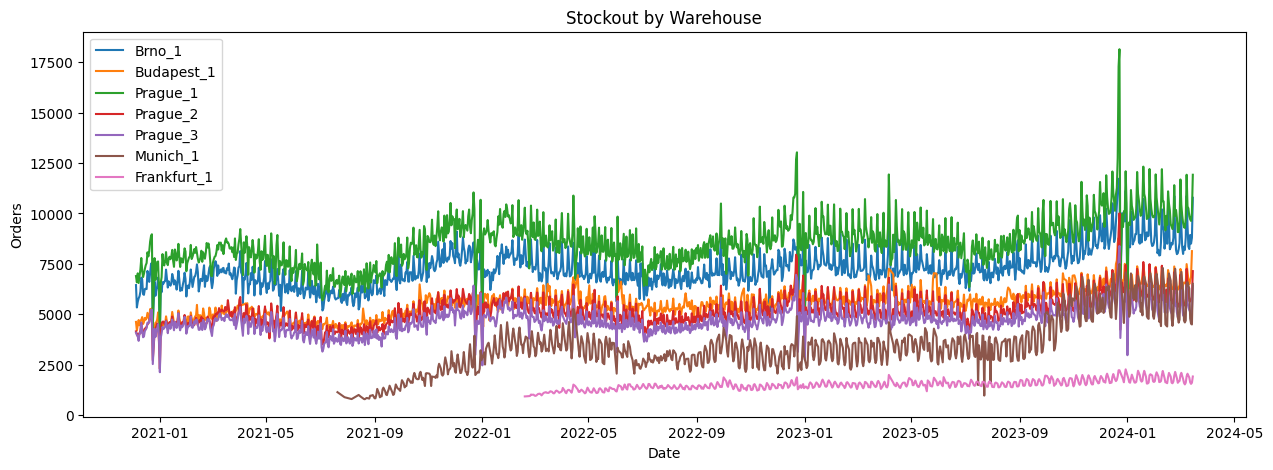

In [94]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

In [95]:
train_df['orders'].describe()

count     7340.000000
mean      5535.443869
std       2182.680279
min        790.000000
25%       4434.000000
50%       5370.000000
75%       7009.250000
max      18139.000000
Name: orders, dtype: float64

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

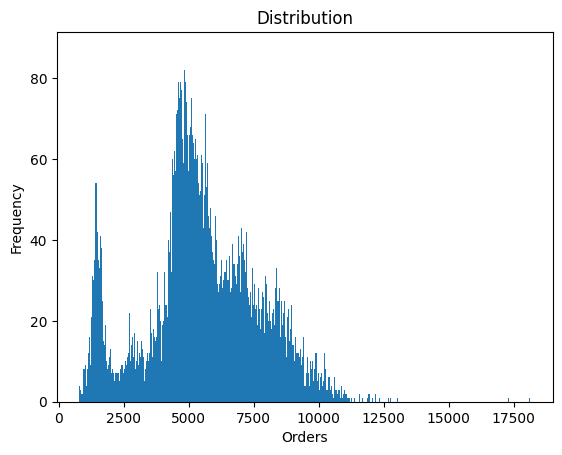

In [96]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

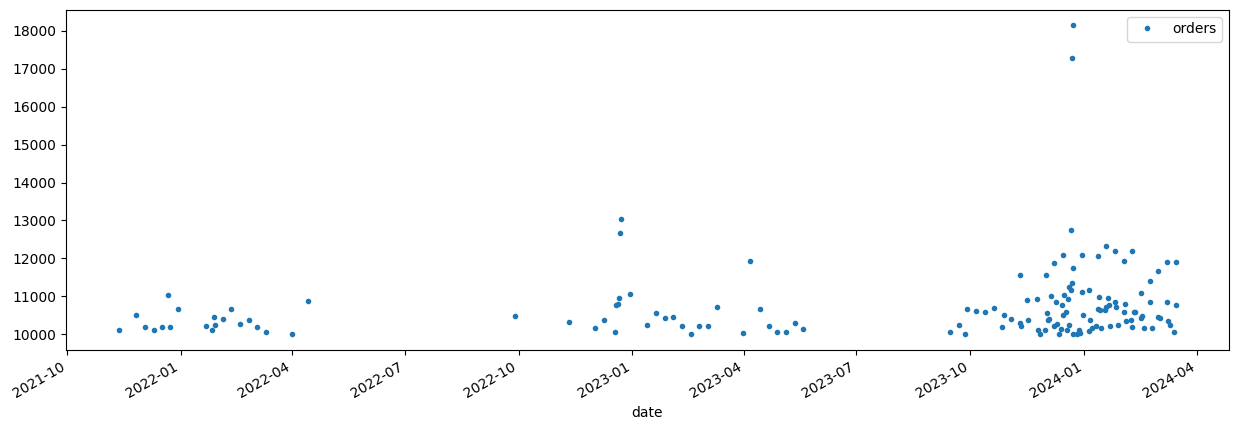

In [97]:
train_df.query('orders > 10000').plot(y='orders', figsize=(15, 5), style='.')

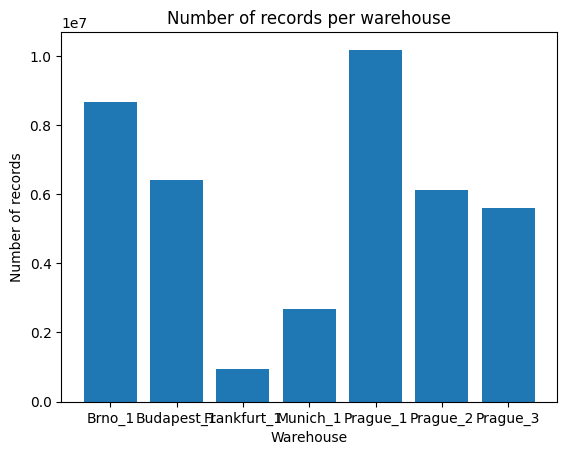

In [98]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

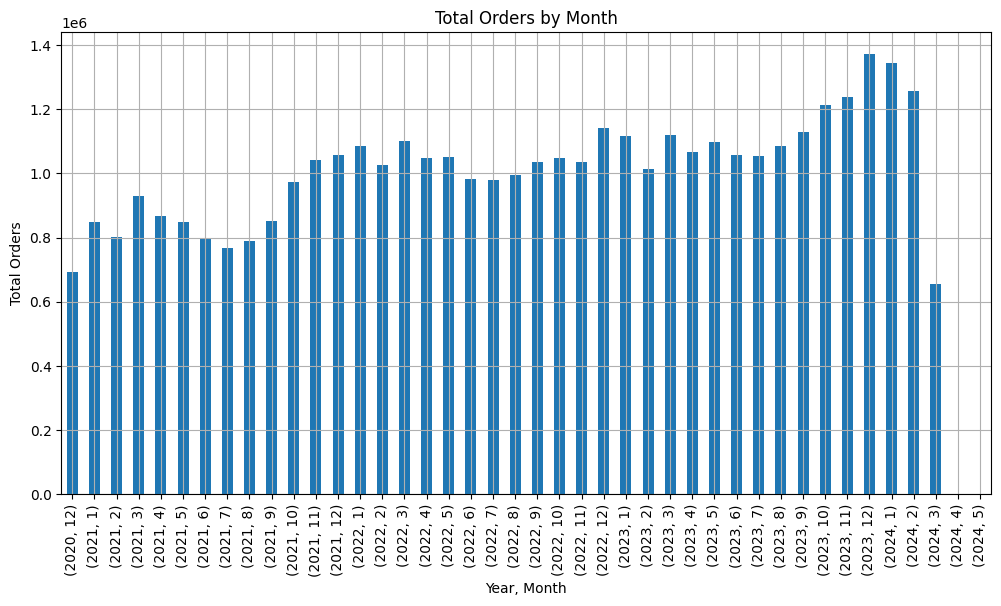

In [99]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

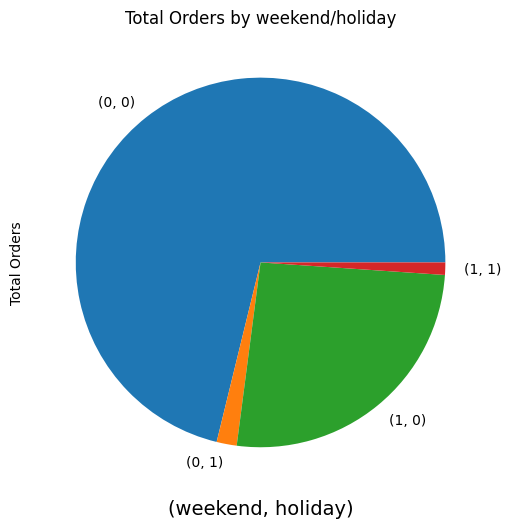

In [100]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [101]:
train_df_corr = train_df.drop(columns=['warehouse', "id", 'holiday_name']).corr()
#train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

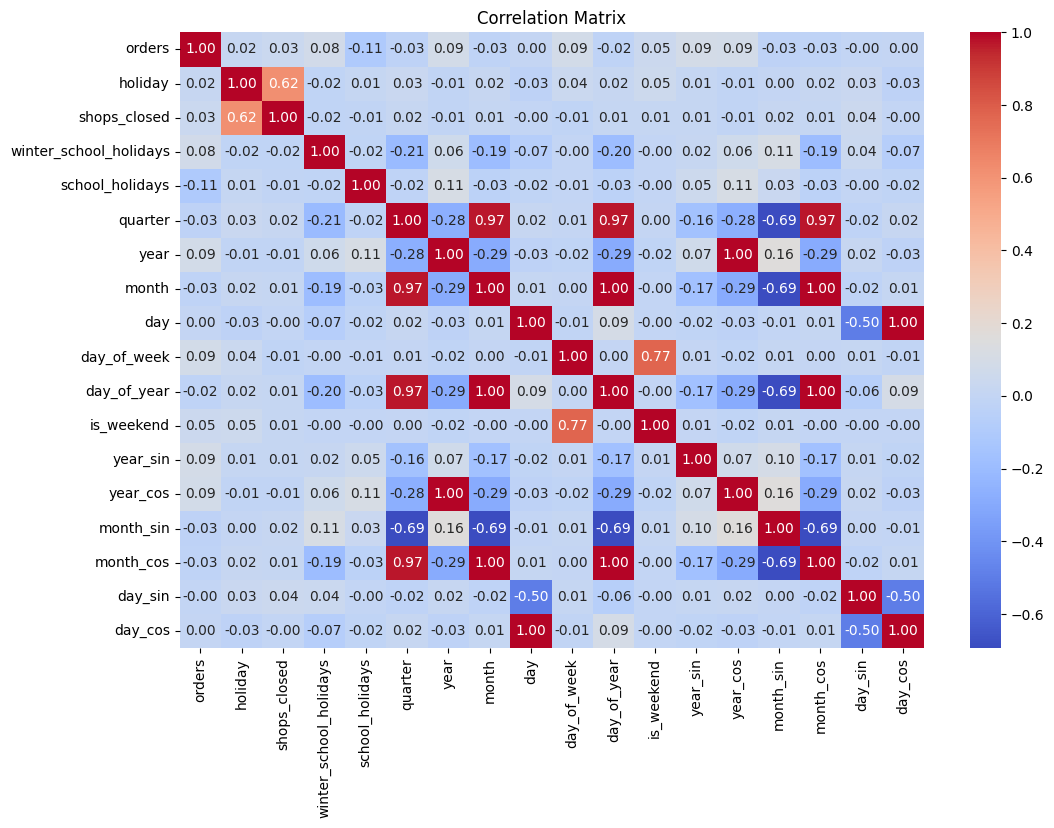

orders                    1.000000
year_sin                  0.087547
day_of_week               0.086522
year                      0.085920
year_cos                  0.085920
winter_school_holidays    0.077211
is_weekend                0.046594
shops_closed              0.034824
holiday                   0.018006
day                       0.002689
day_cos                   0.002689
day_sin                  -0.003553
day_of_year              -0.024332
month                    -0.025271
month_cos                -0.025271
month_sin                -0.029229
quarter                  -0.029323
school_holidays          -0.105071
Name: orders, dtype: float64


In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Remove Outliers

In [103]:

Q1 = train_df['orders'].quantile(0.25)
Q3 = train_df['orders'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.1 * IQR


iqr_outliers = train_df[(train_df['orders'] < lower_bound) | (train_df['orders'] > upper_bound)]

# Print number of outliers identified by each method
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

iqr_outliers.head()


Number of IQR outliers: 5


,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos
date,,,,,,,,,,,,,,,,,,,,,
2022-12-22,Prague_1,12661.0,noholiday,0,0,0,0,Prague_1_2022-12-22,4,2022,12,22,3,356,0,-2.639248e-09,2022.0,-3.526983e-14,12.0,-4.311846e-13,22.0
2022-12-23,Prague_1,13028.0,noholiday,0,0,0,0,Prague_1_2022-12-23,4,2022,12,23,4,357,0,-2.639248e-09,2022.0,-3.526983e-14,12.0,-2.929925e-13,23.0
2023-12-21,Prague_1,12744.0,noholiday,0,0,0,0,Prague_1_2023-12-21,4,2023,12,21,3,355,0,-1.304240e-09,2023.0,-3.526983e-14,12.0,4.120013e-14,21.0
2023-12-22,Prague_1,17282.0,noholiday,0,0,0,0,Prague_1_2023-12-22,4,2023,12,22,4,356,0,-1.304240e-09,2023.0,-3.526983e-14,12.0,-4.311846e-13,22.0
2023-12-23,Prague_1,18139.0,noholiday,0,0,0,0,Prague_1_2023-12-23,4,2023,12,23,5,357,1,-1.304240e-09,2023.0,-3.526983e-14,12.0,-2.929925e-13,23.0


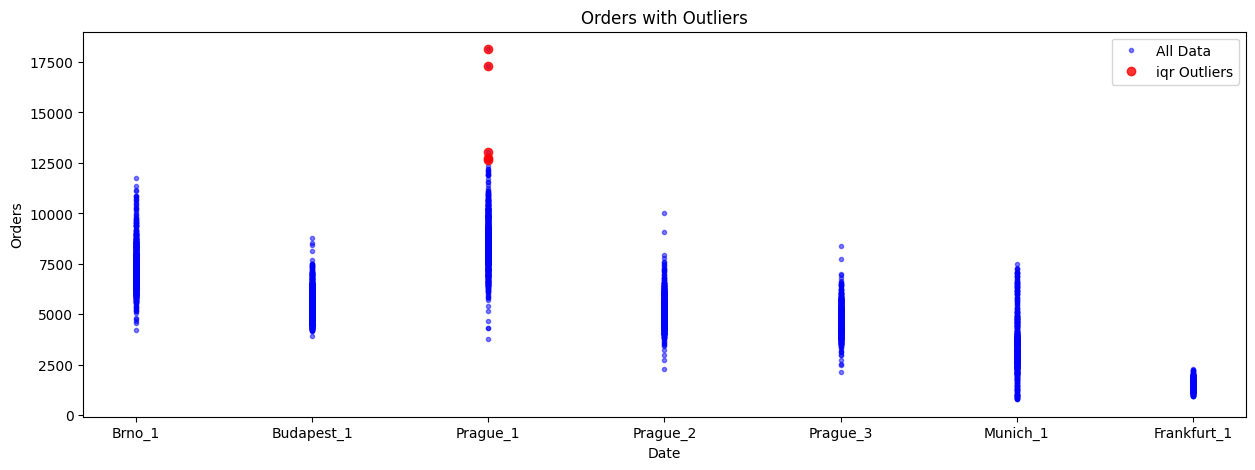

In [104]:
# Plot all data points
plt.figure(figsize=(15, 5))
plt.plot(train_df.warehouse, train_df['orders'], 'b.', alpha=0.5, label='All Data')

# Highlight outliers
plt.plot(iqr_outliers.warehouse, iqr_outliers['orders'], 'ro', alpha=0.8, label='iqr Outliers')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders with Outliers')
plt.legend()
plt.show()

In [105]:
# Drop outliers
#train_df = train_df.drop(iqr_outliers.index)

# Do not drop outliers but fix their values to be average

train_df.loc[iqr_outliers.index, 'orders'] = train_df['orders'].mean()

#### Time Series Cross Validation



In [106]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=398, gap=1) # gap - 24house between train gata end - test data start
cross_val_train_df = train_df.sort_index()

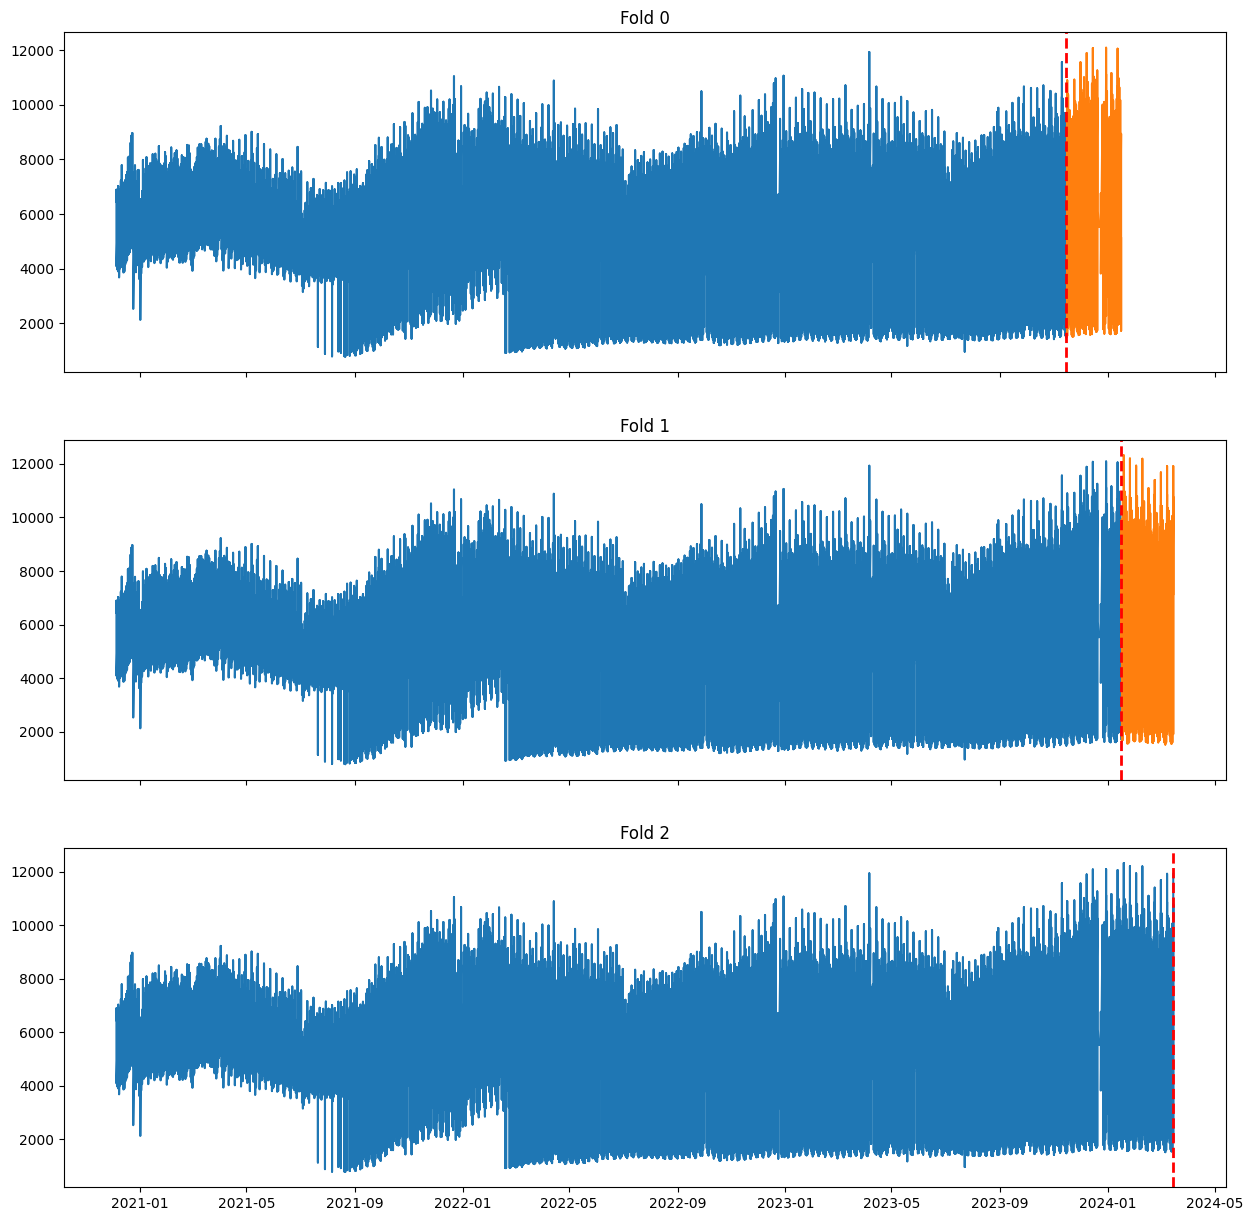

In [107]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(cross_val_train_df):
    train = cross_val_train_df.iloc[train_idx]
    test = cross_val_train_df.iloc[test_idx]
    
    ax[fold].plot(train.index, train['orders'], label='Train')
    ax[fold].plot(test.index, test['orders'], label='Test')
    ax[fold].set_title(f"Fold {fold}")
    ax[fold].axvline(train.index[-1], color='r', linestyle='--', lw=2)
    
    fold += 1

plt.show()

### Temporal features

In [108]:
train_df.head()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos
date,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,noholiday,0,0,0,0,Brno_1_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0
2020-12-05,Budapest_1,4623.0,noholiday,0,0,0,0,Budapest_1_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0
2020-12-05,Prague_1,6895.0,noholiday,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0
2020-12-05,Prague_2,4154.0,noholiday,0,0,0,0,Prague_2_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0
2020-12-05,Prague_3,4091.0,noholiday,0,0,0,0,Prague_3_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0


In [109]:
LAG_DAYS = [1, 7, 14, 28]
ROLLING_WINDOW = [7, 14, 28]

In [110]:
# Create lag features
def create_lag_features(df, col, lag_days):
    lag_features = []
    # create lag features for each warehouse, stop at the last dataset day even if the lag is not complete
    for lag in lag_days:
        df[f'{col}_lag_{lag}'] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(f'{col}_lag_{lag}')
    return df, lag_features


# Create rolling statistics
def create_rolling_features(df, col, windows):
    window_features = []
    # create rolling features for each warehouse, stop at the last dataset day even if the lag is not complete
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'{col}_rolling_std_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        window_features.extend([f'{col}_rolling_mean_{window}', f'{col}_rolling_std_{window}'])
    return df, window_features


In [111]:
# Apply the functions
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Combine the features for easier visualization
numerical_features = ['orders']
numerical_features += lag_features + window_features
categorical_features=categorical_features + ['warehouse', 'holiday_name']
#categorical_features=categorical_features + ['warehouse']

print(numerical_features)

train_df.head()

['orders', 'orders_lag_1', 'orders_lag_7', 'orders_lag_14', 'orders_lag_28', 'orders_rolling_mean_7', 'orders_rolling_std_7', 'orders_rolling_mean_14', 'orders_rolling_std_14', 'orders_rolling_mean_28', 'orders_rolling_std_28']


,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,noholiday,0,0,0,0,Brno_1_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,6447.0,NaN,6447.0,NaN,6447.0,NaN
2020-12-05,Budapest_1,4623.0,noholiday,0,0,0,0,Budapest_1_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4623.0,NaN,4623.0,NaN,4623.0,NaN
2020-12-05,Prague_1,6895.0,noholiday,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,6895.0,NaN,6895.0,NaN,6895.0,NaN
2020-12-05,Prague_2,4154.0,noholiday,0,0,0,0,Prague_2_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4154.0,NaN,4154.0,NaN,4154.0,NaN
2020-12-05,Prague_3,4091.0,noholiday,0,0,0,0,Prague_3_2020-12-05,4,2020,12,5,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4091.0,NaN,4091.0,NaN,4091.0,NaN


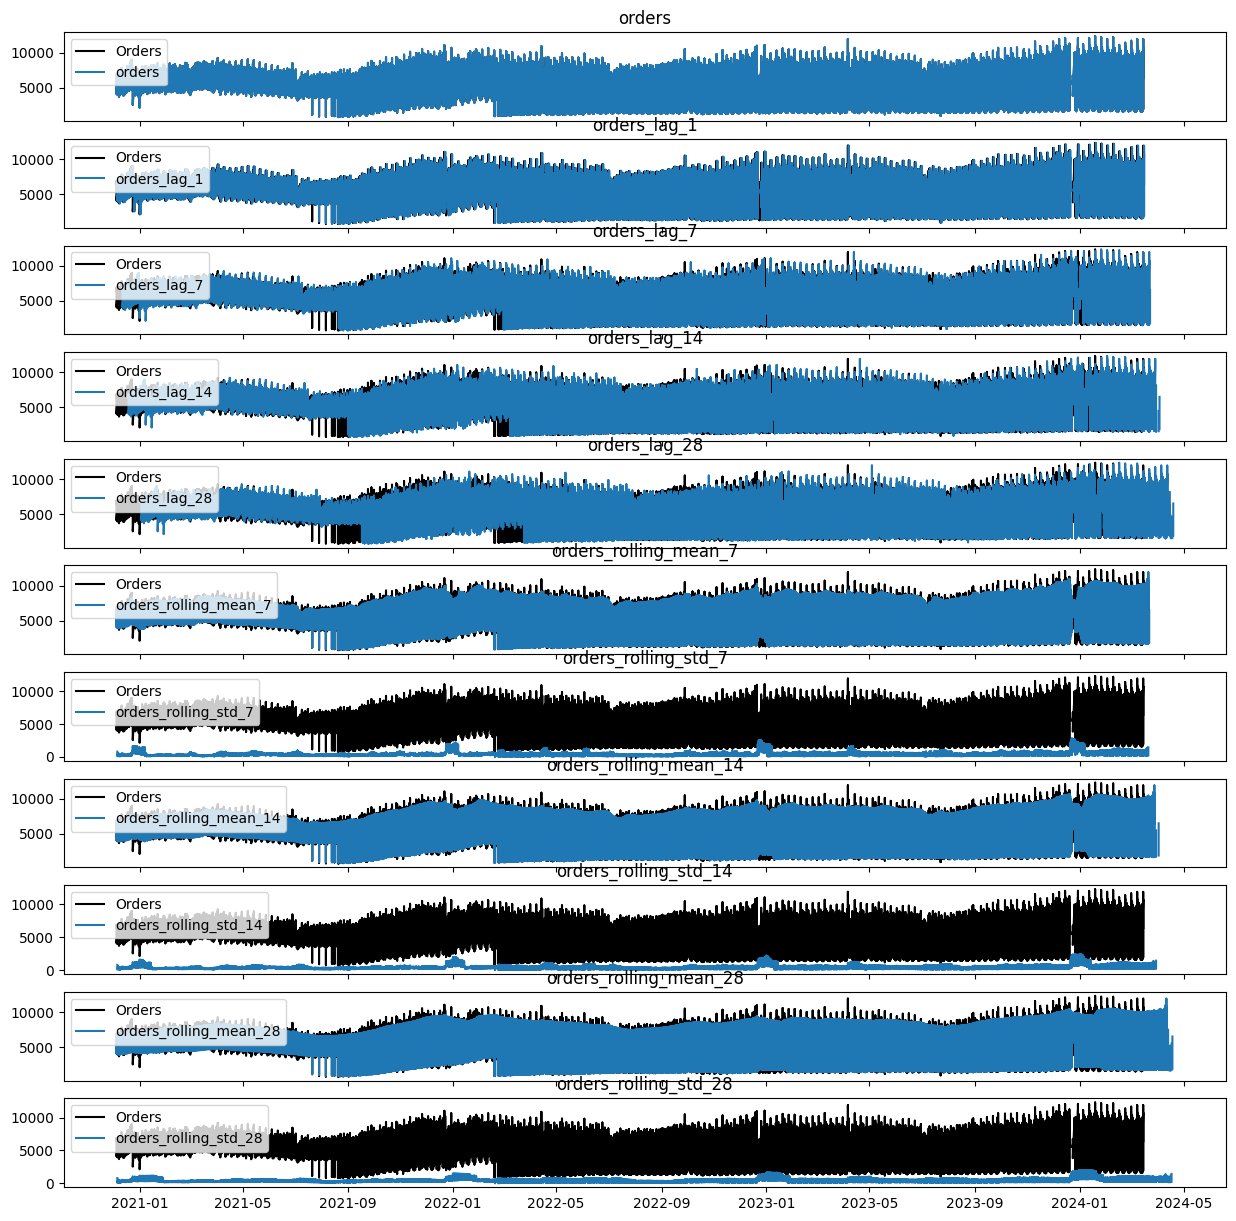

In [112]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df.index, train_df['orders'], label='Orders', color='black')
    ax[i].plot(train_df.index, train_df[feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


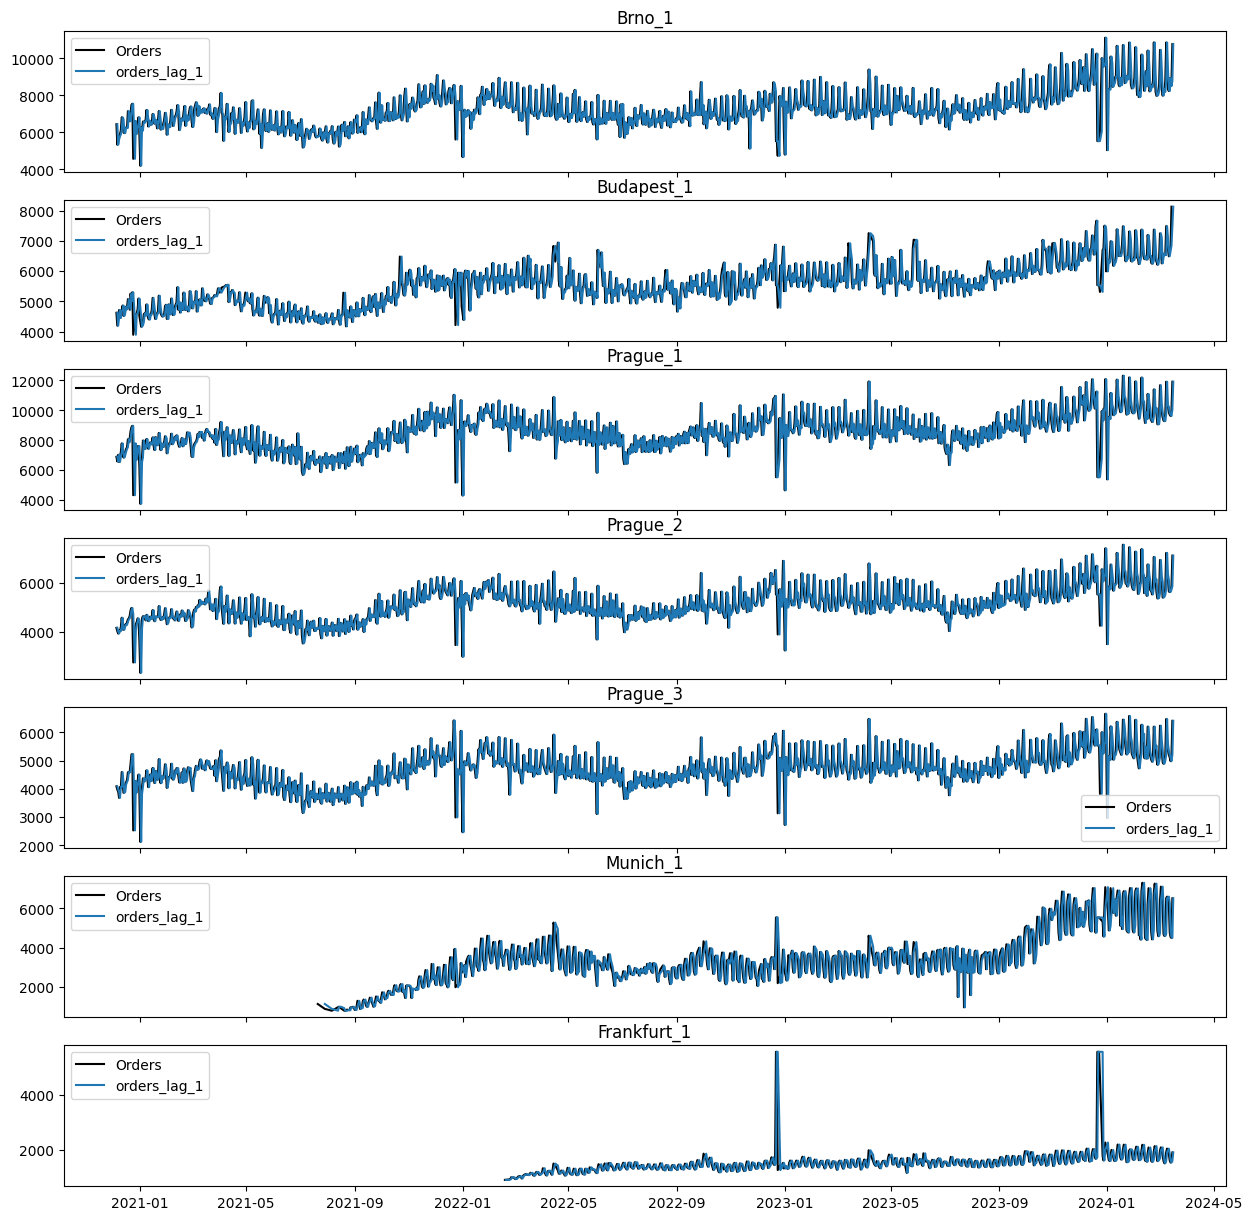

In [113]:
# make plots for every warehouse with with lag 98 feature
feature = f'orders_lag_{LAG_DAYS[0]}'

fig, ax = plt.subplots(len(train_df['warehouse'].unique()), 1, figsize=(15, 15), sharex=True)
for i, warehouse in enumerate(train_df['warehouse'].unique()):
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    ax[i].plot(warehouse_df.index, warehouse_df['orders'], label='Orders', color='black')
    ax[i].plot(warehouse_df.index, warehouse_df[feature], label=feature)
    ax[i].set_title(warehouse)
    ax[i].legend()
plt.show()

In [114]:
# divide dataset back into train and test datasets according to the dates from the original datasets:
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

C:\Users\ondre\AppData\Local\Temp\ipykernel_18472\1761043157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"] = test_df.index


In [115]:
train_df.tail()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-15,Frankfurt_1,1916.0,noholiday,0,0,0,0,Frankfurt_1_2024-03-15,1,2024,3,15,4,75,0,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.616905e-13,15.0,1608.0,1610.0,1663.0,1844.0,1793.714286,194.376537,1776.357143,197.292289,1773.750000,193.275015
2024-03-15,Munich_1,6512.0,noholiday,0,0,0,0,Munich_1_2024-03-15,1,2024,3,15,4,75,0,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.616905e-13,15.0,4496.0,4694.0,4584.0,6128.0,5674.142857,1009.772487,5575.785714,989.362202,5546.464286,1036.562463
2024-03-15,Prague_1,11917.0,noholiday,0,0,0,0,Prague_1_2024-03-15,1,2024,3,15,4,75,0,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.616905e-13,15.0,10056.0,11917.0,11683.0,11095.0,10253.000000,780.089525,10135.214286,831.482196,10030.214286,809.959960
2024-03-15,Prague_2,7140.0,noholiday,0,0,0,0,Prague_2_2024-03-15,1,2024,3,15,4,75,0,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.616905e-13,15.0,5880.0,7253.0,6960.0,6773.0,6079.714286,539.780423,6021.714286,581.466902,5990.928571,549.579498
2024-03-15,Prague_3,6408.0,noholiday,0,0,0,0,Prague_3_2024-03-15,1,2024,3,15,4,75,0,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.616905e-13,15.0,5208.0,6473.0,6235.0,6203.0,5409.571429,480.802058,5392.142857,503.600094,5366.750000,466.662351


In [116]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 31)
Test data: (397, 31)


In [117]:
test_df.to_csv('data/test_proc.csv')

In [118]:
train_df = train_df.drop(columns=['id'])
#train_df = train_df.drop(columns=['id', 'holiday_name'])

### OH encoding of categorical features

In [119]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[categorical_features])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    
# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

if 'holiday_name_nan' in encoded_df.columns:
    encoded_df = encoded_df.drop(columns=['holiday_name_nan'])
    encoded_feature_names = encoded_feature_names.tolist()
    encoded_feature_names.remove('holiday_name_nan')
print(encoded_feature_names)    

encoded_df.index = train_df.index

# Concatenate the encoded features with the original DataFrame
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical.joblib')

['day_of_week_0' 'day_of_week_1' 'day_of_week_2' 'day_of_week_3'
 'day_of_week_4' 'day_of_week_5' 'day_of_week_6' 'warehouse_Brno_1'
 'warehouse_Budapest_1' 'warehouse_Frankfurt_1' 'warehouse_Munich_1'
 'warehouse_Prague_1' 'warehouse_Prague_2' 'warehouse_Prague_3'
 'holiday_name_1848 Revolution Memorial Day (Extra holiday)'
 'holiday_name_2nd Christmas Day' "holiday_name_All Saints' Day Holiday"
 'holiday_name_Christmas Eve' 'holiday_name_Cyrila a Metodej'
 'holiday_name_Day of National Unity'
 'holiday_name_Den boje za svobodu a demokracii'
 'holiday_name_Den ceske statnosti' 'holiday_name_Den osvobozeni'
 'holiday_name_Den vzniku samostatneho ceskoslovenskeho statu'
 'holiday_name_Easter Monday' 'holiday_name_Good Friday'
 'holiday_name_Independent Hungary Day'
 'holiday_name_International womens day' 'holiday_name_Jan Hus'
 'holiday_name_Labour Day'
 'holiday_name_Memorial Day for the Martyrs of Arad'
 'holiday_name_Memorial Day for the Victims of the Communist Dictatorships'
 'hol

c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical.joblib']

In [120]:
train_df= train_df.drop(columns=categorical_features)

In [121]:
train_df.head()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_noholiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,6447.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,6447.0,NaN,6447.0,NaN,6447.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,4623.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4623.0,NaN,4623.0,NaN,4623.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,6895.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,6895.0,NaN,6895.0,NaN,6895.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,4154.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4154.0,NaN,4154.0,NaN,4154.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,4091.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4091.0,NaN,4091.0,NaN,4091.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


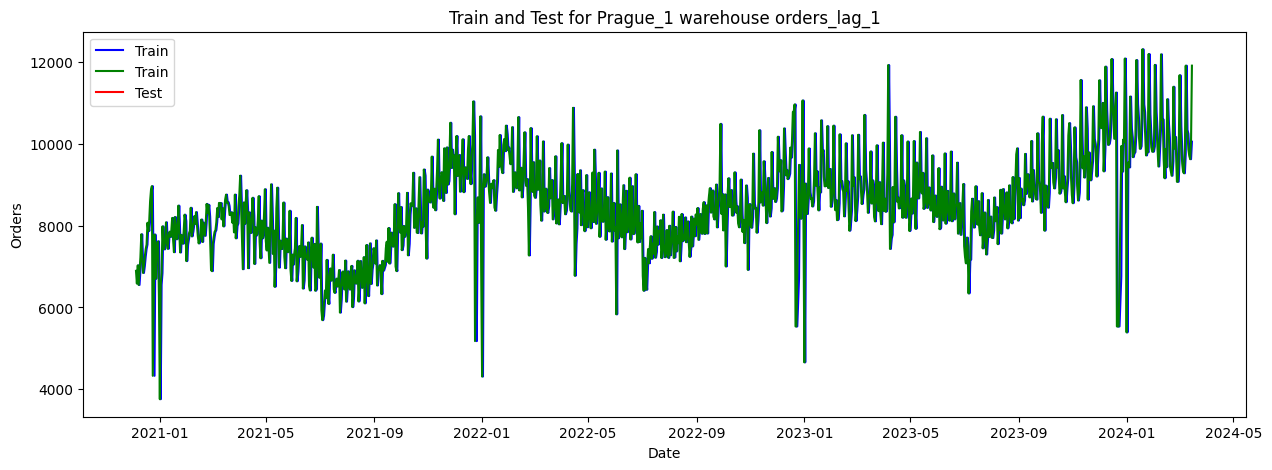

In [122]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
feature = f'orders_lag_{LAG_DAYS[0]}'

plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse_Prague_1'] == 1]
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax[feature], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')


plt.title(f'Train and Test for Prague_1 warehouse {feature}')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

### Min-Max scale numerical features

In [123]:
train_df.head()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_noholiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,6447.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,6447.0,NaN,6447.0,NaN,6447.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,4623.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4623.0,NaN,4623.0,NaN,4623.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,6895.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,6895.0,NaN,6895.0,NaN,6895.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,4154.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4154.0,NaN,4154.0,NaN,4154.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,4091.0,0,0,0,0,4,2020,12,5,340,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,NaN,NaN,NaN,NaN,4091.0,NaN,4091.0,NaN,4091.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [124]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 66)
Test data: (397, 31)


In [125]:
print(train_df.isna().sum())  # Check for Nas

orders                                     0
holiday                                    0
shops_closed                               0
winter_school_holidays                     0
school_holidays                            0
                                          ..
holiday_name_National Defense Day          0
holiday_name_New Years Day                 0
holiday_name_Peace Festival in Augsburg    0
holiday_name_Reformation Day               0
holiday_name_noholiday                     0
Length: 66, dtype: int64


In [126]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'num_features': numerical_features,
    'cat_features': categorical_features,
    'time_features': time_features,
}

joblib.dump(scaler_config, 'scaler_config.joblib')

['scaler_config.joblib']

In [127]:
train_df = train_df.fillna(0)

In [128]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [129]:
"""drop nan values of these columns 
orders_lag_98                                                                
orders_lag_196                                                             
orders_lag_364                                                              
orders_rolling_mean_98                                                         
orders_rolling_std_98                                                          
orders_rolling_mean_364                                                        
orders_rolling_std_364     
"""
subset = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        subset.append(feature)
print(subset)
#train_df = train_df.dropna(subset=subset)
                     
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())                               

['orders_lag_1', 'orders_lag_7', 'orders_lag_14', 'orders_lag_28', 'orders_rolling_mean_7', 'orders_rolling_std_7', 'orders_rolling_mean_14', 'orders_rolling_std_14', 'orders_rolling_mean_28', 'orders_rolling_std_28']
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [130]:
train_df.describe()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_noholiday
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7.340000e+03,7340.000000,7.340000e+03,7340.000000,7.340000e+03,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000
mean,5523.108929,0.027248,0.010899,0.029973,0.007084,2.456948,2022.167711,6.379019,15.677112,178.565123,0.262534,-1.386149e-09,2022.167711,-1.923069e-14,6.379019,-9.340990e-14,15.677112,5515.915468,5479.929501,5437.867784,5354.158792,5515.651915,424.413813,5507.435261,432.783854,5492.227543,449.639108,0.144414,0.147820,0.149046,0.148365,0.147820,0.147820,0.114714,0.162534,0.157221,0.085695,0.106948,0.162534,0.162534,0.162534,0.000136,0.002180,0.000136,0.003134,0.001635,0.000409,0.001635,0.001635,0.001635,0.001635,0.001635,0.001635,0.000409,0.003542,0.001635,0.001635,0.000409,0.000545,0.000409,0.000545,0.000409,0.002180,0.000272,0.000272,0.970300
std,2159.190614,0.162816,0.103836,0.170524,0.083876,1.153169,0.951798,3.587490,8.764848,109.640686,0.440041,9.793352e-10,0.951798,2.789274e-14,3.587490,1.685724e-13,8.764848,2162.988972,2193.735479,2227.745665,2292.604842,2105.662412,284.969524,2101.040295,271.014398,2097.382535,255.184484,0.351533,0.354946,0.356158,0.355486,0.354946,0.354946,0.318698,0.368965,0.364034,0.279932,0.309068,0.368965,0.368965,0.368965,0.011672,0.046641,0.011672,0.055894,0.040403,0.020214,0.040403,0.040403,0.040403,0.040403,0.040403,0.040403,0.020214,0.059415,0.040403,0.040403,0.020214,0.023340,0.020214,0.023340,0.020214,0.046641,0.016506,0.016506,0.169771
min,790.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2020.000000,1.000000,1.000000,1.000000,0.000000,-2.639248e-09,2020.000000,-1.077962e-13,1.000000,-6.467621e-13,1.000000,0.000000,0.000000,0.000000,0.000000,874.571429,0.000000,891.500000,0.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [131]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
0 days    6147
1 days    1188
2 days       4
Name: count, dtype: int64

### Create Time Series 

In [132]:
X_train = train_df.drop(columns=['orders'])
y_train = train_df['orders']

In [133]:
X_train.shape, y_train.shape

((7340, 65), (7340,))

In [134]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Fit the scaler on the numeriacal columns
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Save the scaler
joblib.dump(x_scaler, 'x_scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')

['y_scaler.joblib']

In [61]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 14
X, y = create_sequences(X_train_scaled, y_train_scaled, time_steps)

X.shape, y.shape

((7326, 14, 65), (7326, 1))

### Data Loading

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)  

### Compile and Fit the model

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

LR = 1e-3
checkpointing = ModelCheckpoint('best_model_lstm.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

"""
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
"""

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=1))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR))

history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_val, y_val), callbacks=[checkpointing])

Epoch 1/100
731/733 [============================>.] - ETA: 0s - loss: 0.3062
Epoch 1: val_loss improved from inf to 0.03663, saving model to best_model_lstm.h5
733/733 [==============================] - 31s 29ms/step - loss: 0.3059 - val_loss: 0.0366
Epoch 2/100
733/733 [==============================] - ETA: 0s - loss: 0.0632
Epoch 2: val_loss improved from 0.03663 to 0.03153, saving model to best_model_lstm.h5
733/733 [==============================] - 20s 27ms/step - loss: 0.0632 - val_loss: 0.0315
Epoch 3/100
732/733 [============================>.] - ETA: 0s - loss: 0.0387
Epoch 3: val_loss did not improve from 0.03153
733/733 [==============================] - 20s 27ms/step - loss: 0.0387 - val_loss: 0.0319
Epoch 4/100
732/733 [============================>.] - ETA: 0s - loss: 0.0353
Epoch 4: val_loss improved from 0.03153 to 0.03091, saving model to best_model_lstm.h5
733/733 [==============================] - 20s 27ms/step - loss: 0.0352 - val_loss: 0.0309
Epoch 5/100
733/733 

In [ ]:
from lightgbm import LGBMRegressor

best_params = {
    'n_estimators': 703,
    'learning_rate': 0.06814945127794421,
    'max_depth': 7,
    'reg_alpha': 0.07569481465417208,
    'reg_lambda': 2.1073371397761793,
    'num_leaves': 28,
    'subsample': 0.8680610615626715,
    'colsample_bytree': 0.893976646492343,
    'min_child_weight': 14,
    'min_split_gain': 0.7643791668215504,
    'subsample_freq': 2,
    'min_child_samples': 18,
    'device': 'gpu',  # Enable GPU support
    'gpu_platform_id': 0,  # Adjust if needed
    'gpu_device_id': 0,    # Adjust if needed
    'verbose': -1  # Suppress LightGBM output
}

model = LGBMRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

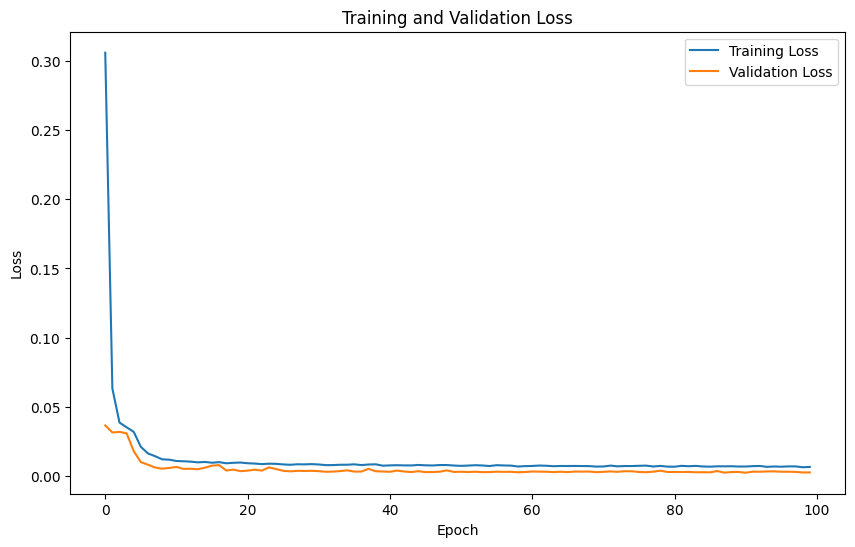

In [64]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Inference

#### MAPE

In [65]:
from sklearn.metrics import mean_absolute_percentage_error
# Evaluate the model on the validation set
#model = tf.keras.models.load_model('best_model_lstm.h5')

val_predictions = model.predict(X_val)
val_predictions = y_scaler.inverse_transform(val_predictions)
y_val_unscaled = y_scaler.inverse_transform(y_val)

mape = mean_absolute_percentage_error(y_val_unscaled, val_predictions) * 100
print(f'Tuned Model Mean Absolute Percentage Error: {mape:.4f}%')

46/46 [==============================] - 2s 16ms/step
Tuned Model Mean Absolute Percentage Error: 7.1185%


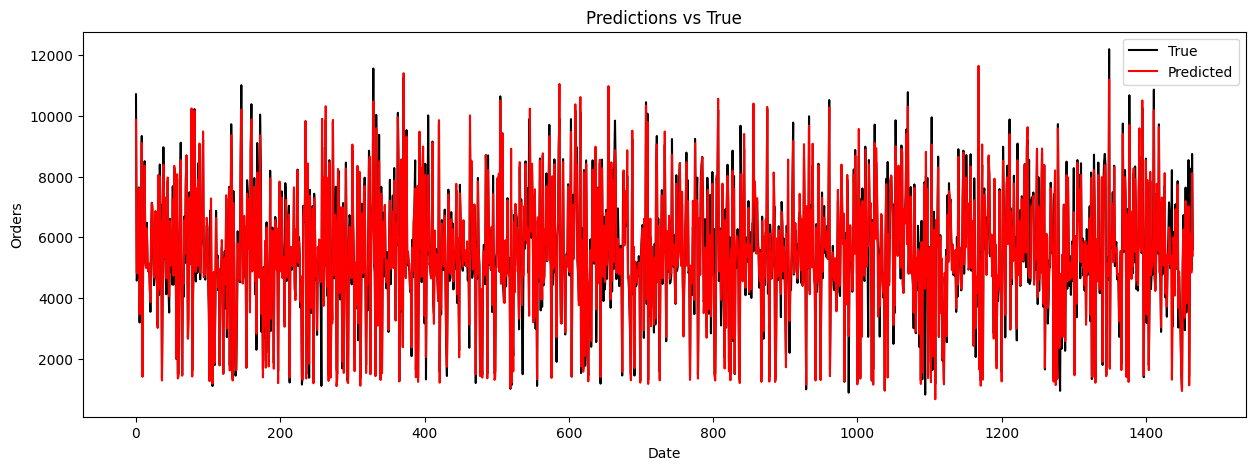

In [66]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
plt.figure(figsize=(15, 5))
plt.plot(y_val_unscaled, label='True', color='black')
plt.plot(val_predictions, label='Predicted', color='red')
plt.title('Predictions vs True')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()


In [135]:
import pandas as pd
import joblib

dataframe = pd.read_csv("data/test_proc.csv")

In [136]:
dataframe.head(10)

,date,warehouse,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28,date.1
0,2024-03-16,Brno_1,noholiday,0,0,0,0,Brno_1_2024-03-16,1,2024,3,16,5,76,1,3.208798e-11,2024.0,-2.204364e-15,3.0,-6.270192e-14,16.0,10777.0,9419.0,9352.0,9529.0,8933.500000,940.068668,8887.153846,936.485081,8840.148148,894.793818,2024-03-16
1,2024-03-16,Budapest_1,noholiday,0,0,0,0,Budapest_1_2024-03-16,1,2024,3,16,5,76,1,3.208798e-11,2024.0,-2.204364e-15,3.0,-6.270192e-14,16.0,8130.0,7488.0,7249.0,7193.0,6993.000000,592.508228,6839.923077,510.073109,6698.555556,460.185191,2024-03-16
2,2024-03-16,Frankfurt_1,noholiday,0,0,0,0,Frankfurt_1_2024-03-16,1,2024,3,16,5,76,1,3.208798e-11,2024.0,-2.204364e-15,3.0,-6.270192e-14,16.0,1916.0,1930.0,1694.0,1623.0,1771.000000,202.496420,1782.692308,203.860812,1779.333333,194.642078,2024-03-16
3,2024-03-16,Munich_1,noholiday,0,0,0,0,Munich_1_2024-03-16,1,2024,3,16,5,76,1,3.208798e-11,2024.0,-2.204364e-15,3.0,-6.270192e-14,16.0,6512.0,6523.0,4738.0,4499.0,5532.666667,1027.345252,5640.230769,998.708012,5585.259259,1035.386386,2024-03-16
4,2024-03-16,Prague_1,noholiday,0,0,0,0,Prague_1_2024-03-16,1,2024,3,16,5,76,1,3.208798e-11,2024.0,-2.204364e-15,3.0,-6.270192e-14,16.0,11917.0,10344.0,10432.0,10488.0,10237.833333,853.413948,10112.384615,860.855053,10013.259259,820.309960,2024-03-16
5,2024-03-16,Prague_2,noholiday,0,0,0,0,Prague_2_2024-03-16,1,2024,3,16,5,76,1,3.208798e-11,2024.0,-2.204364e-15,3.0,-6.270192e-14,16.0,7140.0,6368.0,6284.0,6327.0,6031.666667,574.668136,6001.538462,600.087718,5978.481481,556.012200,2024-03-16
6,2024-03-16,Prague_3,noholiday,0,0,0,0,Prague_3_2024-03-16,1,2024,3,16,5,76,1,3.208798e-11,2024.0,-2.204364e-15,3.0,-6.270192e-14,16.0,6408.0,5596.0,5713.0,5753.0,5378.500000,518.936509,5367.461538,515.275107,5352.444444,469.253772,2024-03-16
7,2024-03-17,Brno_1,noholiday,0,0,0,0,Brno_1_2024-03-17,1,2024,3,17,6,77,1,3.208798e-11,2024.0,-2.204364e-15,3.0,5.000768e-14,17.0,NaN,8361.0,8319.0,8222.0,9048.000000,1003.162250,8934.500000,961.738624,8863.923077,903.775455,2024-03-17
8,2024-03-17,Budapest_1,noholiday,0,0,0,0,Budapest_1_2024-03-17,1,2024,3,17,6,77,1,3.208798e-11,2024.0,-2.204364e-15,3.0,5.000768e-14,17.0,NaN,7099.0,7103.0,6956.0,6971.800000,659.895219,6818.000000,526.318086,6688.653846,466.356254,2024-03-17
9,2024-03-17,Prague_1,noholiday,0,0,0,0,Prague_1_2024-03-17,1,2024,3,17,6,77,1,3.208798e-11,2024.0,-2.204364e-15,3.0,5.000768e-14,17.0,NaN,10250.0,9900.0,10159.0,10235.400000,954.122529,10130.083333,896.660010,10007.653846,836.027796,2024-03-17


In [137]:
import os
xsc = joblib.load(os.path.join("x_scaler.joblib"))
ysc = joblib.load(os.path.join("y_scaler.joblib"))
ohsc = joblib.load(os.path.join("scaler_onehot_categorical.joblib"))

In [138]:
# load scaler config:
scaler_config = joblib.load('scaler_config.joblib')

num_features = scaler_config['num_features']
cat_features = scaler_config['cat_features']
time_features = scaler_config['time_features']
    
print(f"num_features: {num_features}")
print(f"cat_features: {cat_features}")
print(f"time_features: {time_features}")

num_features: ['orders', 'orders_lag_1', 'orders_lag_7', 'orders_lag_14', 'orders_lag_28', 'orders_rolling_mean_7', 'orders_rolling_std_7', 'orders_rolling_mean_14', 'orders_rolling_std_14', 'orders_rolling_mean_28', 'orders_rolling_std_28']
cat_features: ['day_of_week', 'warehouse', 'holiday_name']
time_features: ['year', 'month', 'day', 'day_of_year', 'quarter', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [139]:
from working import preprocess_data
id = dataframe.pop('id')
dataframe.drop(columns=['date.1'], inplace=True)
processed_data = preprocess_data(dataframe, xsc, ohsc, cat_features)

In [140]:
processed_data.head()     

,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_noholiday
0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.5,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.5,0.874828,0.764591,0.759153,0.773521,0.798252,0.336222,0.815075,0.380753,0.828829,0.445799,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.5,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.5,0.659956,0.607842,0.588441,0.583895,0.606042,0.211915,0.606381,0.207384,0.605279,0.229271,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.5,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.5,0.155532,0.156669,0.137511,0.131748,0.088793,0.072424,0.090848,0.082885,0.091789,0.096973,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.5,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.5,0.528614,0.529507,0.384609,0.365208,0.461393,0.367437,0.484085,0.406052,0.489069,0.515844,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.5,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.5,0.967367,0.839679,0.846822,0.851368,0.927449,0.305229,0.939975,0.350004,0.951283,0.408690,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [141]:
processed_data.shape

(397, 65)

In [142]:
# Compare the columns in the original and processed dataframes

X_columns = set(train_df.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("this df has the same columns as the training df.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in train_df:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

The dataframes have different columns.
Columns present only in train_df:
{'orders'}


In [143]:
processed_data = processed_data.fillna(0)

In [144]:
processed_data.head(10)

,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_noholiday
0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.500000,0.874828,0.764591,0.759153,0.773521,0.798252,0.336222,0.815075,0.380753,0.828829,0.445799,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.500000,0.659956,0.607842,0.588441,0.583895,0.606042,0.211915,0.606381,0.207384,0.605279,0.229271,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.500000,0.155532,0.156669,0.137511,0.131748,0.088793,0.072424,0.090848,0.082885,0.091789,0.096973,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.500000,0.528614,0.529507,0.384609,0.365208,0.461393,0.367437,0.484085,0.406052,0.489069,0.515844,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.500000,0.967367,0.839679,0.846822,0.851368,0.927449,0.305229,0.939975,0.350004,0.951283,0.408690,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.500000,0.579592,0.516925,0.510106,0.513597,0.510820,0.205534,0.520916,0.243982,0.530115,0.277013,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.205479,1.0,1.0,1.0,0.981781,0.181818,0.686587,0.500000,0.520172,0.454258,0.463755,0.467002,0.446123,0.185601,0.456278,0.209499,0.464766,0.233789,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.533333,0.208219,1.

In [145]:
processed_data.describe()

,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,is_weekend,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_1,orders_lag_7,orders_lag_14,orders_lag_28,orders_rolling_mean_7,orders_rolling_std_7,orders_rolling_mean_14,orders_rolling_std_14,orders_rolling_mean_28,orders_rolling_std_28,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,holiday_name_noholiday
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.0,397.000000,397.000000,397.000000,397.000000,397.0,397.0,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.0,397.0,397.0,397.0,397.0,397.0,397.0,397.0,397.000000,397.0,397.000000,397.000000,397.0,397.0,397.0,397.000000,397.0,397.0,397.000000,397.0,397.0,397.0,397.0,397.0,397.000000
mean,0.068010,0.020151,0.020151,0.070529,0.247691,1.0,0.271353,0.492863,0.287878,0.269521,1.0,1.0,0.964980,0.271353,0.648680,0.492863,0.010796,0.064805,0.127932,0.253565,0.060909,0.025407,0.132247,0.062741,0.275832,0.157020,0.151134,0.158690,0.151134,0.136020,0.133501,0.158690,0.110831,0.153652,0.143577,0.120907,0.120907,0.153652,0.153652,0.153652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010076,0.0,0.010076,0.010076,0.0,0.0,0.0,0.010076,0.0,0.0,0.002519,0.0,0.0,0.0,0.0,0.0,0.957179
std,0.252081,0.140694,0.140694,0.256359,0.145830,0.0,0.064268,0.288115,0.048259,0.444271,0.0,0.0,0.012906,0.064268,0.202575,0.288115,0.087046,0.188294,0.246943,0.295745,0.198238,0.089424,0.275114,0.134217,0.343774,0.197031,0.358631,0.365848,0.358631,0.343243,0.340545,0.365848,0.314319,0.361070,0.351103,0.326430,0.326430,0.361070,0.361070,0.361070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099996,0.0,0.099996,0.099996,0.0,0.0,0.0,0.099996,0.0,0.0,0.050189,0.0,0.0,0.0,0.0,0.0,0.202709
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.181818,0.000000,0.205479,0.000000,1.0,1.0,0.945344,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.181818,0.233333,0.246575,0.000000,1.0,1.0,0.965840,0.181818,0.570222,0.233333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.

In [146]:
import numpy as np

timestamps = 14

X_infer = []
for i in range(timestamps, len(processed_data)):
    X_infer.append(processed_data.iloc[i-timestamps:i].values)
X_infer = np.array(X_infer)

X_infer.shape

(383, 14, 65)

In [147]:
import tensorflow as tf

In [148]:
model = tf.keras.models.load_model('best_model_lstm.h5')

In [149]:
predictions = model.predict(X_infer)

12/12 [==============================] - 1s 22ms/step


In [150]:
predictions.shape  

(383, 1)

In [152]:
# Rescale the predictions to original scale:
predictions_rescaled = ysc.inverse_transform(predictions)

#put the predictions into the dataframe with "id" and "orders" columns
submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions_rescaled.flatten()})

submission_df.to_csv('submission_rescaled.csv', index=False)
submission_df.head()

,id,orders
0,Brno_1_2024-03-16,1800.584839
1,Budapest_1_2024-03-16,5538.949219
2,Frankfurt_1_2024-03-16,8799.127930
3,Munich_1_2024-03-16,5279.335449
4,Prague_1_2024-03-16,5007.818848


In [153]:
# Add the date column as an index and warehouse column to the rescaled predictions 
submission_df['date'] = dataframe['date']
submission_df['warehouse'] = dataframe['warehouse']
submission_df.head(10)

,id,orders,date,warehouse
0,Brno_1_2024-03-16,1800.584839,2024-03-16,Brno_1
1,Budapest_1_2024-03-16,5538.949219,2024-03-16,Budapest_1
2,Frankfurt_1_2024-03-16,8799.127930,2024-03-16,Frankfurt_1
3,Munich_1_2024-03-16,5279.335449,2024-03-16,Munich_1
4,Prague_1_2024-03-16,5007.818848,2024-03-16,Prague_1
5,Prague_2_2024-03-16,7857.758789,2024-03-16,Prague_2
6,Prague_3_2024-03-16,5844.131836,2024-03-16,Prague_3
7,Brno_1_2024-03-17,1590.702026,2024-03-17,Brno_1
8,Budapest_1_2024-03-17,4559.883301,2024-03-17,Budapest_1
9,Prague_1_2024-03-17,8425.404297,2024-03-17,Prague_1


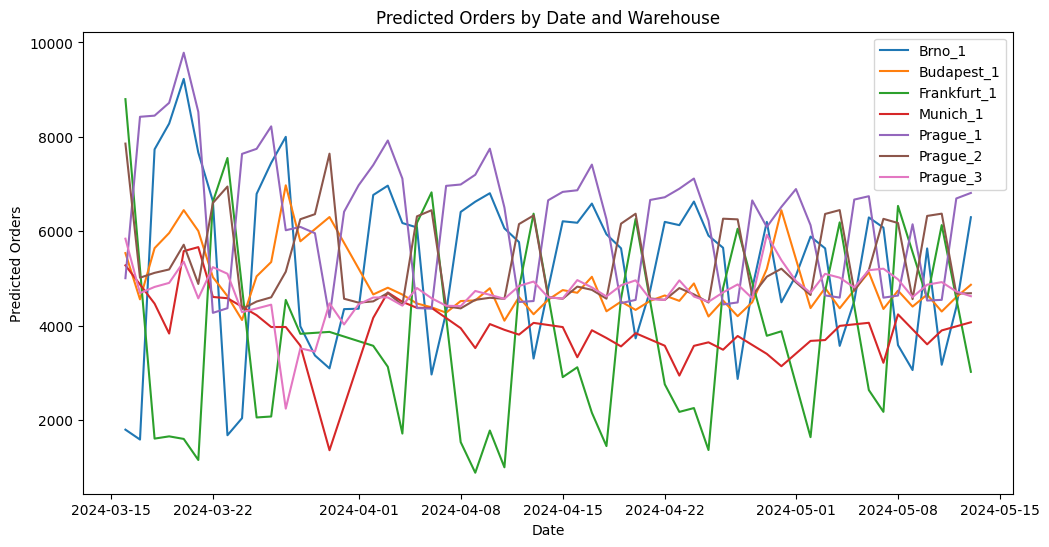

In [154]:
import matplotlib.pyplot as plt
# Visualise rescaled predictions with date for every warehouse on the same plot
warehouses = submission_df['warehouse'].unique()
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=wh)
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()

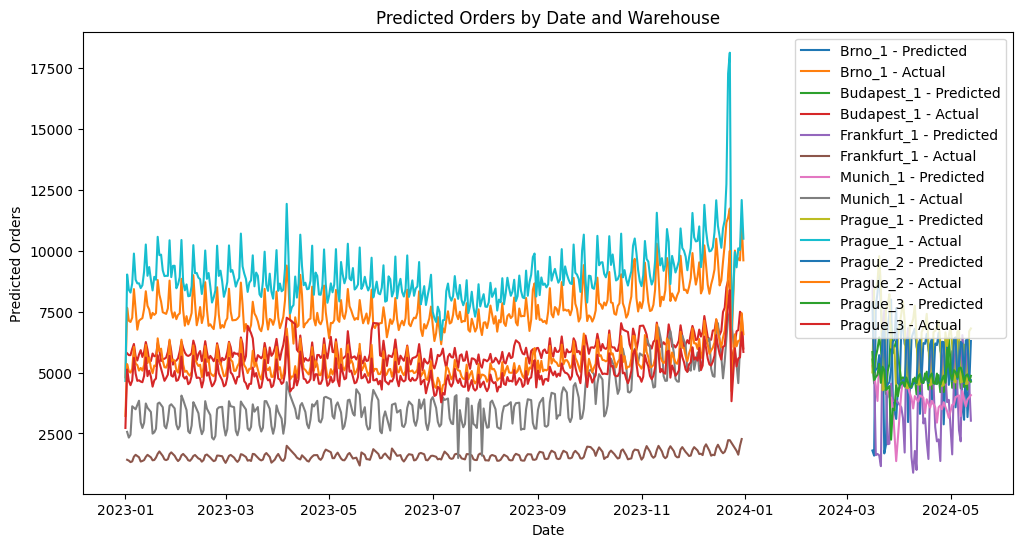

In [155]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=f'{wh} - Predicted')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label=f'{wh} - Actual')
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()


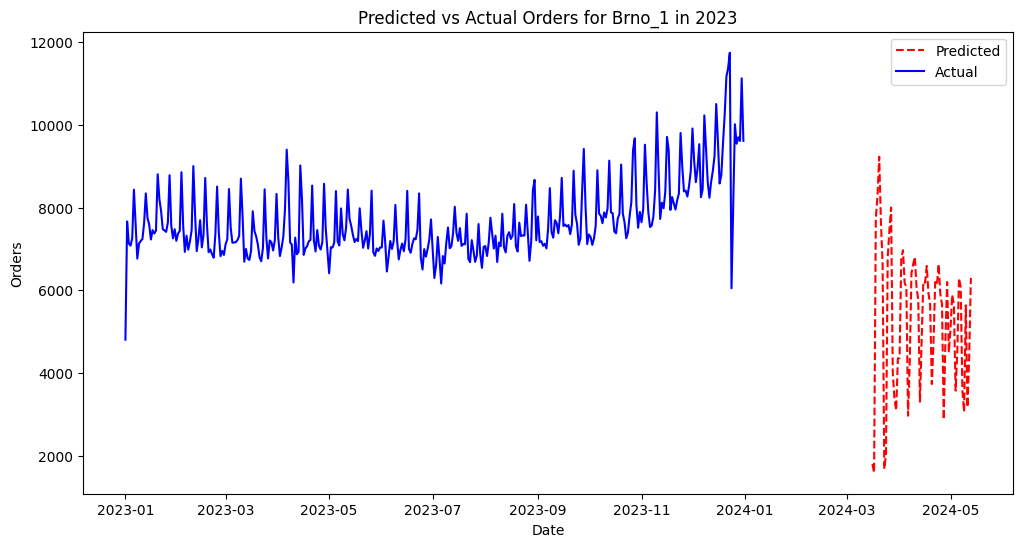

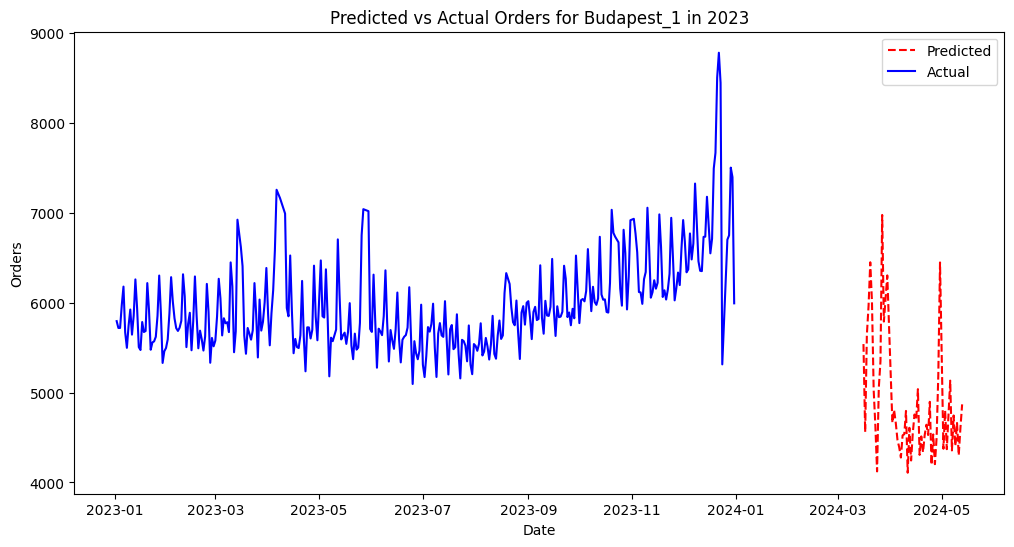

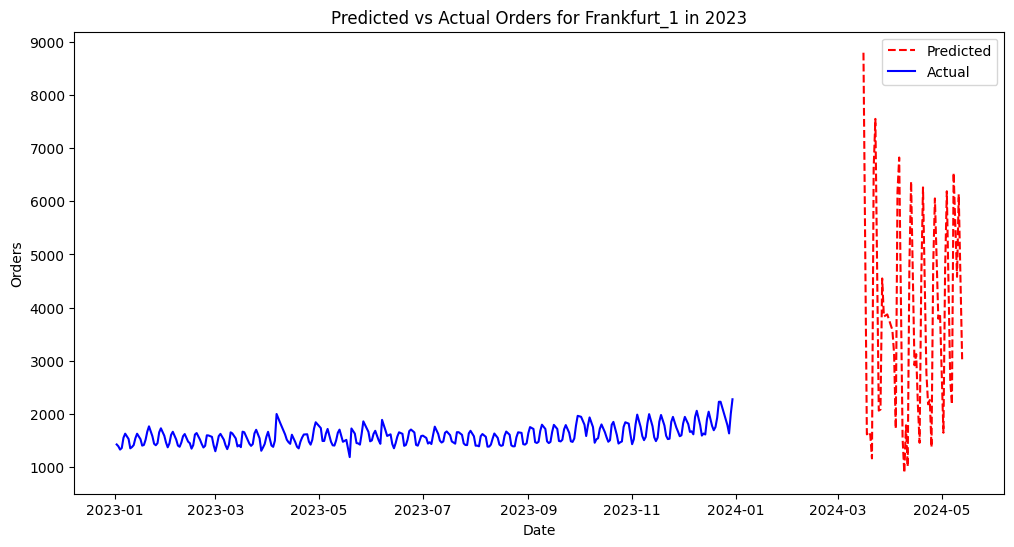

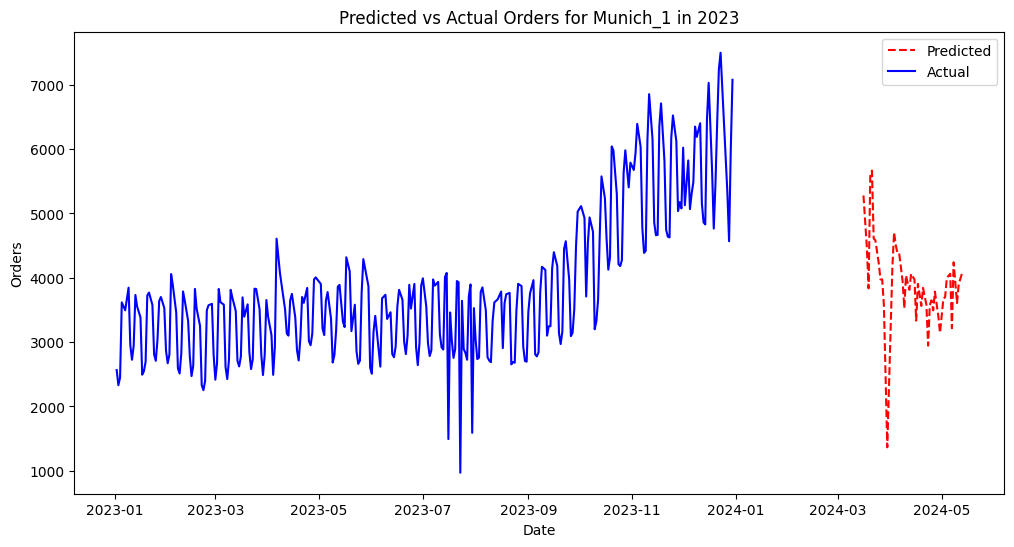

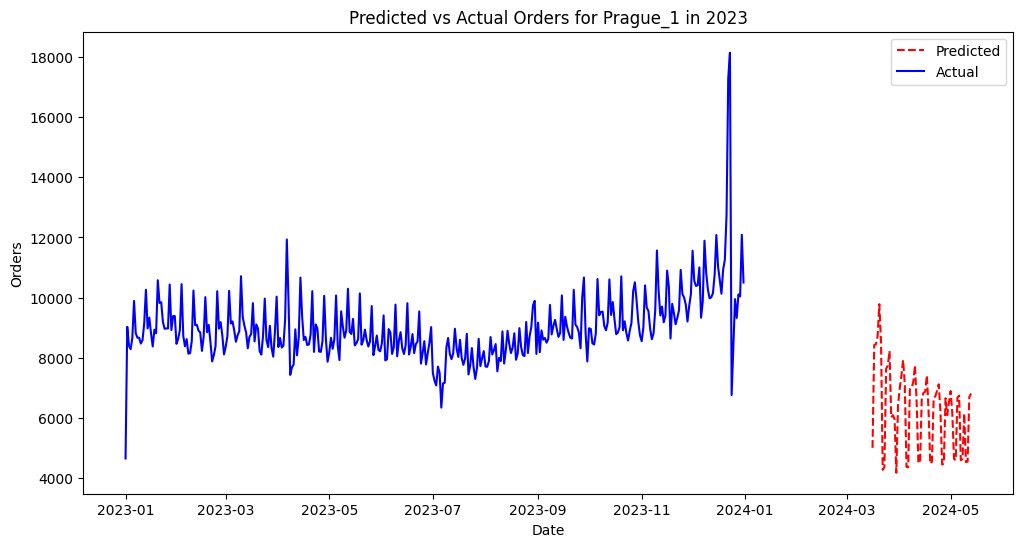

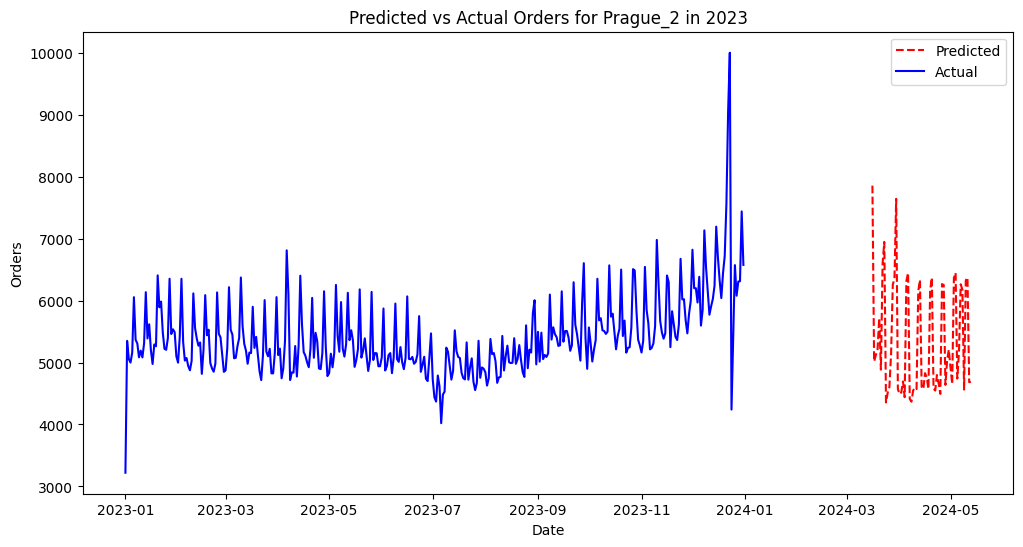

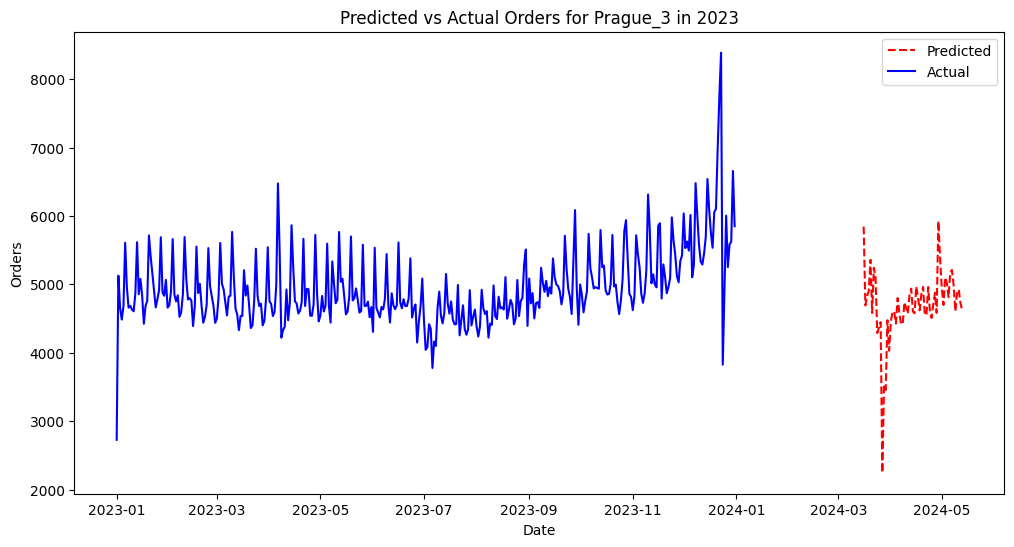

In [156]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these dataframes are already loaded
# train_df_raw: Raw training data
# submission_df_rescaled: Rescaled predictions
# warehouses: List of warehouse names

# Filter training data for the year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]

# Create separate plots for each warehouse
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    
    plt.figure(figsize=(12, 6))
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', linestyle='--', color='r')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='b')
    plt.title(f'Predicted vs Actual Orders for {wh} in 2023')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
